
# MPC for a 2D Mobile Robot (Linear Model) with CasADi

This notebook builds a **Model Predictive Controller (MPC)** in **CasADi** to track a reference trajectory for a simple linear mobile-robot model.  
We use a double-integrator model in 2D:
- **States**: \(x = [p_x, p_y, v_x, v_y]^\top\)
- **Inputs**: \(u = [a_x, a_y]^\top\)
- **Dynamics (discrete)**: \(x_{k+1} = A x_k + B u_k\)

We set up an MPC with a quadratic cost and input bounds, and run it in closed loop.



## Setup

If you don't have CasADi installed yet:
```bash
pip install casadi
```
This notebook also uses `numpy` and `matplotlib` (usually already available).


In [2]:
pip install casadi

     |████████████████████████████████| 75.6 MB 9.9 MB/s eta 0:00:012
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt

# Make plots a bit larger
plt.rcParams["figure.figsize"] = (6, 4)

def circle_reference(t, R=5.0, w=0.2, cx=0.0, cy=0.0):
    # Simple circular reference in 2D position. Velocity reference is optional (here set to 0).
    # t: time in seconds
    # Returns (px_ref, py_ref, vx_ref, vy_ref)
    px = cx + R * np.cos(w * t)
    py = cy + R * np.sin(w * t)
    vx = 0.0
    vy = 0.0
    return np.array([px, py, vx, vy])


In [4]:

# ===== Discrete-time linear model (double integrator) =====
dt = 0.1  # [s] sample time

A = np.array([
    [1, 0, dt, 0 ],
    [0, 1, 0 , dt],
    [0, 0, 1 , 0 ],
    [0, 0, 0 , 1 ]
], dtype=float)

B = np.array([
    [0.5*dt**2, 0.0        ],
    [0.0       , 0.5*dt**2 ],
    [dt        , 0.0        ],
    [0.0       , dt         ]
], dtype=float)

nx = A.shape[0]
nu = B.shape[1]

# ===== MPC horizon & weights =====
N = 25  # prediction horizon (steps)

# Tracking cost: sum (x - x_ref)^T Q (x - x_ref) + u^T R u
Q = np.diag([10.0, 10.0, 0.1, 0.1])
R = np.diag([0.1, 0.1])

# Optional terminal weight (can be larger to encourage end-of-horizon accuracy)
Qf = np.diag([20.0, 20.0, 0.2, 0.2])

# ===== Input constraints =====
u_min = np.array([-2.0, -2.0])
u_max = np.array([ 2.0,  2.0])

# ===== Build the Opti problem =====
opti = ca.Opti()

# Decision variables
X = opti.variable(nx, N+1)  # states x_0 ... x_N
U = opti.variable(nu, N)    # inputs u_0 ... u_{N-1}

# Parameters (provided at solve time)
x0_param = opti.parameter(nx)          # current state
xref_param = opti.parameter(nx, N+1)   # reference over horizon (may be time-varying)

# Initial condition constraint
opti.subject_to(X[:, 0] == x0_param)

# Dynamics constraints
A_cas = ca.DM(A)
B_cas = ca.DM(B)
for k in range(N):
    x_next = ca.mtimes(A_cas, X[:, k]) + ca.mtimes(B_cas, U[:, k])
    opti.subject_to(X[:, k+1] == x_next)

# Input constraints
for k in range(N):
    opti.subject_to(u_min <= U[:, k])
    opti.subject_to(U[:, k] <= u_max)

# Objective
obj = 0
for k in range(N):
    e = X[:, k] - xref_param[:, k]
    obj += ca.mtimes([e.T, Q, e]) + ca.mtimes([U[:, k].T, R, U[:, k]])
# Terminal cost
eN = X[:, N] - xref_param[:, N]
obj += ca.mtimes([eN.T, Qf, eN])

opti.minimize(obj)

# Solver options
p_opts = {"print_time": False}
s_opts = {"print_level": 0, "warm_start_init_point": "yes"}
opti.solver("ipopt", p_opts, s_opts)

print("MPC problem constructed.")


MPC problem constructed.


In [5]:

# ===== Closed-loop simulation =====

T_sim = 40.0   # total simulation time [s]
sim_steps = int(T_sim / dt)

# Initial state
x = np.array([6.0, 0.0, 0.0, 0.0], dtype=float)

# Logging
xs = np.zeros((nx, sim_steps+1))
us = np.zeros((nu, sim_steps))
refs = np.zeros((nx, sim_steps+1))
ts = np.arange(sim_steps+1) * dt

xs[:, 0] = x
refs[:, 0] = circle_reference(0.0)

# Warm start containers
u_guess = np.zeros((nu, N))
x_guess = np.tile(x.reshape(-1,1), (1, N+1))

for t_idx in range(sim_steps):
    t_now = t_idx * dt

    # Build reference over horizon
    xref_h = np.zeros((nx, N+1))
    for k in range(N+1):
        t_pred = t_now + k*dt
        xref_h[:, k] = circle_reference(t_pred)

    # Set parameters
    opti.set_value(x0_param, x)
    opti.set_value(xref_param, xref_h)

    # Warm start (shift previous solution forward)
    if t_idx > 0:
        # shift u_guess left and repeat last
        u_guess = np.hstack([u_guess[:, 1:], u_guess[:, -1:]])
        # rollout x_guess using dynamics with guessed U
        x_guess[:, 0] = x
        for k in range(N):
            x_guess[:, k+1] = A @ x_guess[:, k] + B @ u_guess[:, k]

    opti.set_initial(U, u_guess)
    opti.set_initial(X, x_guess)

    # Solve
    try:
        sol = opti.solve()
    except RuntimeError as e:
        # If IPOPT has trouble, try without warm start once
        opti.set_initial(U, 0)
        opti.set_initial(X, 0)
        sol = opti.solve()

    # Extract optimal control and predicted state
    u_opt = sol.value(U)[:, 0]
    x_pred = sol.value(X)

    # Apply first control to the real system
    x = A @ x + B @ u_opt

    # Log
    xs[:, t_idx+1] = x
    us[:, t_idx] = u_opt
    refs[:, t_idx+1] = circle_reference((t_idx+1)*dt)

    # Prepare warm start for next step
    u_guess = sol.value(U)
    x_guess = sol.value(X)

print("Simulation finished.")



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Simulation finished.


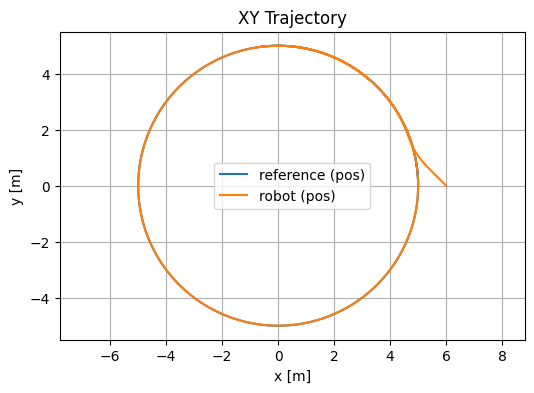

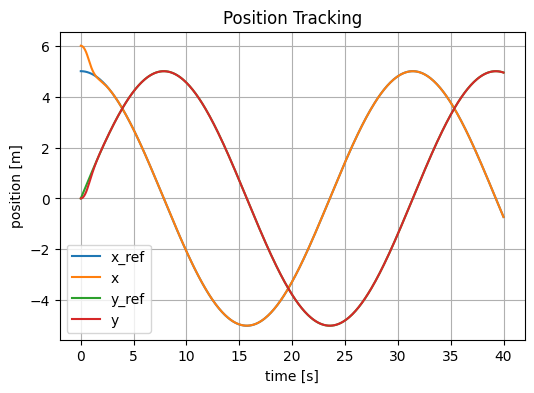

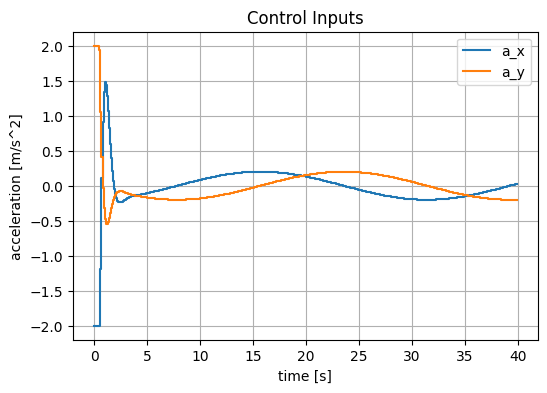

In [6]:

# ===== Plot results =====

# Trajectory in XY
plt.figure()
plt.plot(refs[0, :], refs[1, :], label="reference (pos)")
plt.plot(xs[0, :], xs[1, :], label="robot (pos)")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.title("XY Trajectory")
plt.axis("equal")
plt.legend()
plt.grid(True)
plt.show()

# Position vs time
plt.figure()
plt.plot(ts, refs[0, :], label="x_ref")
plt.plot(ts, xs[0, :], label="x")
plt.plot(ts, refs[1, :], label="y_ref")
plt.plot(ts, xs[1, :], label="y")
plt.xlabel("time [s]")
plt.ylabel("position [m]")
plt.title("Position Tracking")
plt.legend()
plt.grid(True)
plt.show()

# Control inputs
plt.figure()
plt.step(ts[:-1], us[0, :], where="post", label="a_x")
plt.step(ts[:-1], us[1, :], where="post", label="a_y")
plt.xlabel("time [s]")
plt.ylabel("acceleration [m/s^2]")
plt.title("Control Inputs")
plt.legend()
plt.grid(True)
plt.show()



## Notes & Extensions

- **Model**: We used a linear double-integrator. You can switch to a unicycle or differential-drive model and either linearize it or use nonlinear MPC by writing the dynamics directly in CasADi.
- **Constraints**: Add state constraints (e.g., position bounds) by adding `opti.subject_to()` on `X`.
- **Terminal ingredients**: Add a terminal set or LQR terminal cost for better stability guarantees.
- **References**: Replace the circular trajectory with waypoints or a time-varying path/velocity profile.
- **Tuning**: Increase `N` (horizon), and adjust `Q, R, Qf, u_min, u_max` to trade off tracking vs. control effort.
- **Warm-start**: Already included; helps speed up convergence.
